# calibrate cosmic gate timing
Nov-19, 2020

In [287]:
import sys; 
sys.path.insert(0, '/Users/erezcohen/Desktop/PETsys/Software/analysis/Python'); 
sys.path.insert(0, '/Users/erezcohen/Desktop/PETsys/Software/PETsysAnalysis/Python'); 
from PETsys_analysis_tools import *;
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [161]:
sec = 1.e12
nanosec = sec*1e-9
microsec = sec*1e-6
milisec = sec*1e-3
event_timewindow = 100*milisec;

In [232]:
filepath = '/Users/erezcohen/Desktop/data/PETsys/DuSi/TAU_60cm_scintillator_Nov19_2020/'
# filename = 'cosmic_with_trigger_-300nsdelay_th_e8_100sec_single.dat'
# filename = 'cosmic_th_e9_3600sec_single.dat'
filename = 'cosmic_th_e8_1800sec_single.dat'
cosmic = pd.read_csv(filepath+filename,delimiter='\t',names=['time','charge','channel'])

cosmic_trigg = cosmic[cosmic.channel==4128]
cosmic_scint = cosmic[cosmic.channel!=4128]
print len(cosmic_scint),'SiPM fires which are not in cosmic trigger'
print len(cosmic_trigg),'cosmic trigger events'
# cosmic

15187 SiPM fires which are not in cosmic trigger
258 cosmic trigger events


In [268]:
# find cosmic events
# group events of SiPM fired within a narrow timewindow 
cosmic_events = dict()

scint_t = np.array(cosmic_scint.time);
scint_dt = np.concatenate([[0],np.diff(scint_t)])
scint_ch = np.array(cosmic_scint.channel);
scint_q = np.array(cosmic_scint.charge);

event_idx = 0;
event_t,event_dt,event_ch,event_q = [],[],[],[]
event_t_R,event_ch_R,event_q_R,event_t_L,event_ch_L,event_q_L = [],[],[],[],[],[]
event_NSiPMs = 0

i = 0
while i < len(scint_t)-1:
    t = scint_t[i]
    dt = scint_dt[i]
    ch = scint_ch[i]
    q = scint_q[i]
#     print i,t,dt

    if np.abs(dt)<event_timewindow:
        event_t.append(t)
        event_dt.append(dt)
        event_ch.append(ch)
        event_q.append(q)        
        event_NSiPMs += 1
        # R/L
        if (64*6<=ch) and (ch<64*7):
            event_t_R.append(t)
            event_ch_R.append(ch)
            event_q_R.append(q)        
#         elif (64*9<=ch) and (ch<64*10):
        elif (64*8<=ch) and (ch<64*9):
            event_t_L.append(t)
            event_ch_L.append(ch)
            event_q_L.append(q)        
        # step
        i = i+1
        
    else:
        # save event if number of SiPMs that fired is greater than 1
        if event_NSiPMs>0 and len(event_ch_L)>0 and len(event_ch_R)>0:
            event = dict({  'ch':event_ch,'q':event_q,'t':event_t,
                            'dt':event_dt,'NSiPMs':event_NSiPMs,'N_R':len(event_ch_R),'N_L':len(event_ch_L),
                            'ch_R':event_ch_R,'q_R':event_q_R,'t_R':event_t_R,
                            'ch_L':event_ch_L,'q_L':event_q_L,'t_L':event_t_L})
            event['event time'] = np.min(event_t);
            cosmic_events[event_idx] = event
            
            print 'event',event_idx,'at %.1f'%(event['event time']/sec),',',len(event_ch_R),'right SiPMs,',len(event_ch_L),'left SiPMs'#             print event['ch']#             print event['ch_R'],event['ch_L']
            event_idx += 1
            
        # clean arrays anyway
        event_t,event_dt,event_ch,event_q = [],[],[],[]
        event_t_R,event_ch_R,event_q_R,event_t_L,event_ch_L,event_q_L = [],[],[],[],[],[]
        event_NSiPMs = 0
        # step
        i = i+1        

event 0 at 1.6 , 66 right SiPMs, 56 left SiPMs
event 1 at 2.9 , 31 right SiPMs, 19 left SiPMs
event 2 at 5.0 , 6 right SiPMs, 1 left SiPMs
event 3 at 7.8 , 36 right SiPMs, 16 left SiPMs
event 4 at 10.1 , 8 right SiPMs, 1 left SiPMs
event 5 at 10.5 , 6 right SiPMs, 5 left SiPMs
event 6 at 10.6 , 3 right SiPMs, 2 left SiPMs
event 7 at 11.2 , 2 right SiPMs, 1 left SiPMs
event 8 at 13.0 , 18 right SiPMs, 5 left SiPMs
event 9 at 14.5 , 7 right SiPMs, 4 left SiPMs
event 10 at 15.0 , 4 right SiPMs, 3 left SiPMs
event 11 at 16.4 , 8 right SiPMs, 3 left SiPMs
event 12 at 18.0 , 35 right SiPMs, 19 left SiPMs
event 13 at 20.8 , 4 right SiPMs, 2 left SiPMs
event 14 at 21.9 , 5 right SiPMs, 1 left SiPMs
event 15 at 22.1 , 10 right SiPMs, 2 left SiPMs
event 16 at 23.9 , 2 right SiPMs, 2 left SiPMs
event 17 at 26.4 , 7 right SiPMs, 1 left SiPMs
event 18 at 27.0 , 17 right SiPMs, 3 left SiPMs
event 19 at 29.6 , 27 right SiPMs, 12 left SiPMs
event 20 at 30.3 , 3 right SiPMs, 1 left SiPMs
event 21 at 31

In [274]:
# distribution of time intervals between cosmic events
cosmic_event_dt,cosmic_event_time = [],[]

for eventIdx in range(len(cosmic_events)):
    cosmic_event_time.append( cosmic_events[eventIdx]['event time'])
cosmic_event_time = np.array(cosmic_event_time)

for eventIdx in range(len(cosmic_events)-1):
    cosmic_event_dt.append( cosmic_events[eventIdx+1]['event time'] - cosmic_events[eventIdx]['event time'] )    
cosmic_event_dt = np.array(cosmic_event_dt)
# cosmic_event_dt/nanosec

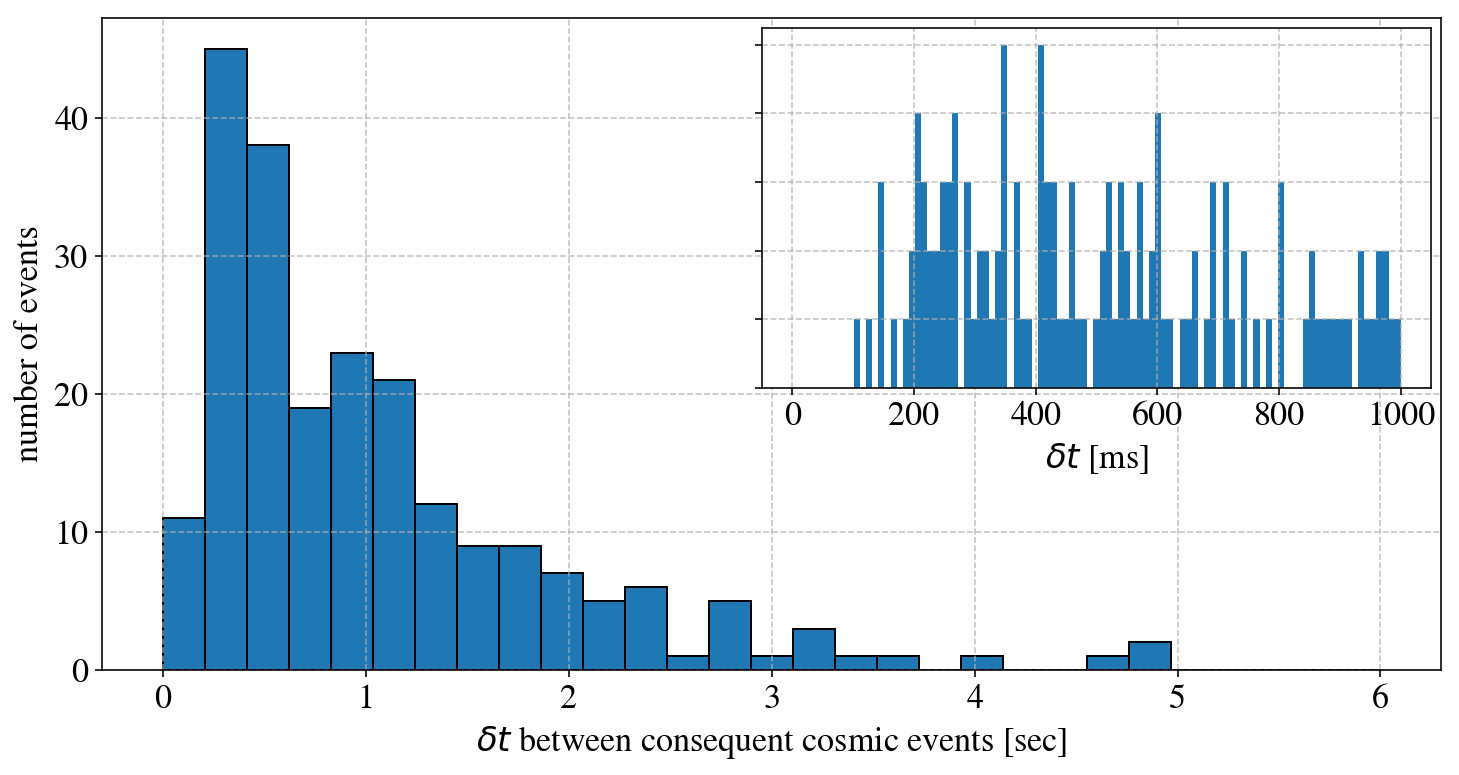

In [275]:
from mpl_toolkits.axes_grid.inset_locator import inset_axes
fig=plt.figure(figsize=(12,6)); 
ax = fig.add_subplot(1,1,1); 
plt.hist( cosmic_event_dt/sec , bins=np.linspace(0,6,30), edgecolor='k');
set_axes(ax=ax,x_label='$\delta t$ between consequent cosmic events [sec]', y_label='number of events',
#          ylim=(0,250),
         fontsize=17,do_add_grid=True,do_add_legend=False);


inset_axes = inset_axes(ax, 
                    width="50%", # of parent_bbox
                    height=2.5, # height : 1 inch
                    loc=1)
# n, bins, patches = plt.hist(s, 400, normed=1)
#plt.title('Probability')
# plt.xticks([])
# plt.yticks([])
plt.hist( cosmic_event_dt/milisec , bins=np.linspace(0,1000,100));
set_axes(ax=inset_axes,x_label='$\delta t$ [ms]', y_label='',remove_ticks_y=True,
         fontsize=17,do_add_grid=True,do_add_legend=False);

# ax.set_xscale('log')

## now open a time window around each cosmic event triggered by the finger scintllators, and compute the time resolution of this event

In [279]:
print len(cosmic_trigg_time),'cosmic triggered events triggered by finger scintillators', cosmic_trigg_time/sec
# print 
finger_trig_time_window = 200*milisec
cosmic_trigg_time = np.array(cosmic_trigg[cosmic_trigg.charge==1].time)
NgoodEvents = 0

for scintIdx in range(len(cosmic_event_time)):
    t_event = cosmic_event_time[scintIdx]
    event = cosmic_events[scintIdx]
    
    #     print 'cosmic event at time ',t_event
    print ('cosmic event %d at time %.1f'%(scintIdx,t_event/sec)),'sec',event['N_L'],'left SiPMs',event['N_R'],'right SiPMs'
    for cosmicTrigIdx in range(len(cosmic_trigg_time)):
        t_trig = cosmic_trigg_time[cosmicTrigIdx]
        #         print t_trig, np.abs(t_event - t_trig)
        if (np.abs(t_event - t_trig)<finger_trig_time_window):
            
            print 'cosmic event',scintIdx,'corresponds with cosmic trigger',cosmicTrigIdx
            q_L, q_R, t_L, t_R = event['q_L'],event['q_R'],event['t_L'],event['t_R']
            
            if len(event['t_L'])>0 and len(event['t_R'])>0:
                NgoodEvents += 1
            
                dt = get_all_differences_R_L(t_L,t_R)            
                event['dt'] = dt            
                event['mean(dt)'] = np.nanmean(dt)
                event['NSiPMs left'] = len(q_L)
                event['NSiPMs right'] = len(q_R)
                event['mean NSiPMs'] = (len(q_L)+len(q_R))/2.
                event['Qtot'] = np.sum(q_L) + np.sum(q_R)
                event['Qavg'] = event['Qtot']/(len(q_L)+len(q_R))
                cosmic_events[scintIdx] = event
#             print event['dt']
#             print event['mean(dt)'],event['Qtot'],event['mean NSiPMs']
#             print  ch_L, ch_R
print NgoodEvents,'good events'
# To continue here, need to: 
# (1) accumulate many events
# (2) verify that a time window of 100 ms is reasonable and not too large....
# (3) compute monets of dt distribution, as a function of Qtot

129 cosmic triggered events triggered by finger scintillators [1.61020425e+00 2.93610504e+00 1.42566624e+01 1.73322200e+01
 4.96654616e+01 9.45422878e+01 1.12682930e+02 1.45974671e+02
 1.81842348e+02 1.87003063e+02 2.09334535e+02 2.20928801e+02
 2.46108626e+02 2.52108774e+02 3.00966434e+02 3.57866764e+02
 3.75264485e+02 3.80524085e+02 3.99934901e+02 4.19098762e+02
 4.21414499e+02 4.35816841e+02 4.36628817e+02 4.43245146e+02
 4.60009622e+02 4.72632007e+02 4.79569120e+02 4.91824673e+02
 4.97525186e+02 4.99051740e+02 5.27036145e+02 5.29174374e+02
 5.31998897e+02 5.42956515e+02 5.46328075e+02 5.54589722e+02
 5.70449243e+02 5.97315852e+02 6.07712806e+02 6.18874481e+02
 6.34339385e+02 6.71179047e+02 6.83160848e+02 6.86128206e+02
 7.10873468e+02 7.11208510e+02 7.71815838e+02 7.80366691e+02
 7.86608237e+02 8.07905640e+02 8.22503540e+02 8.59578311e+02
 8.67864917e+02 8.98386243e+02 9.00310023e+02 9.04002111e+02
 9.17971859e+02 9.26114734e+02 9.36858743e+02 9.49233206e+02
 9.56688152e+02 9.72218

In [237]:
def get_all_differences_R_L(t_L,t_R):#{
    # compute time differences between all combinations of t_L and t_R
    mesh = np.array(np.meshgrid(t_R,t_L))
    combinations = mesh.T.reshape(-1, 2)
    dt = np.diff(combinations)
    return dt
#}

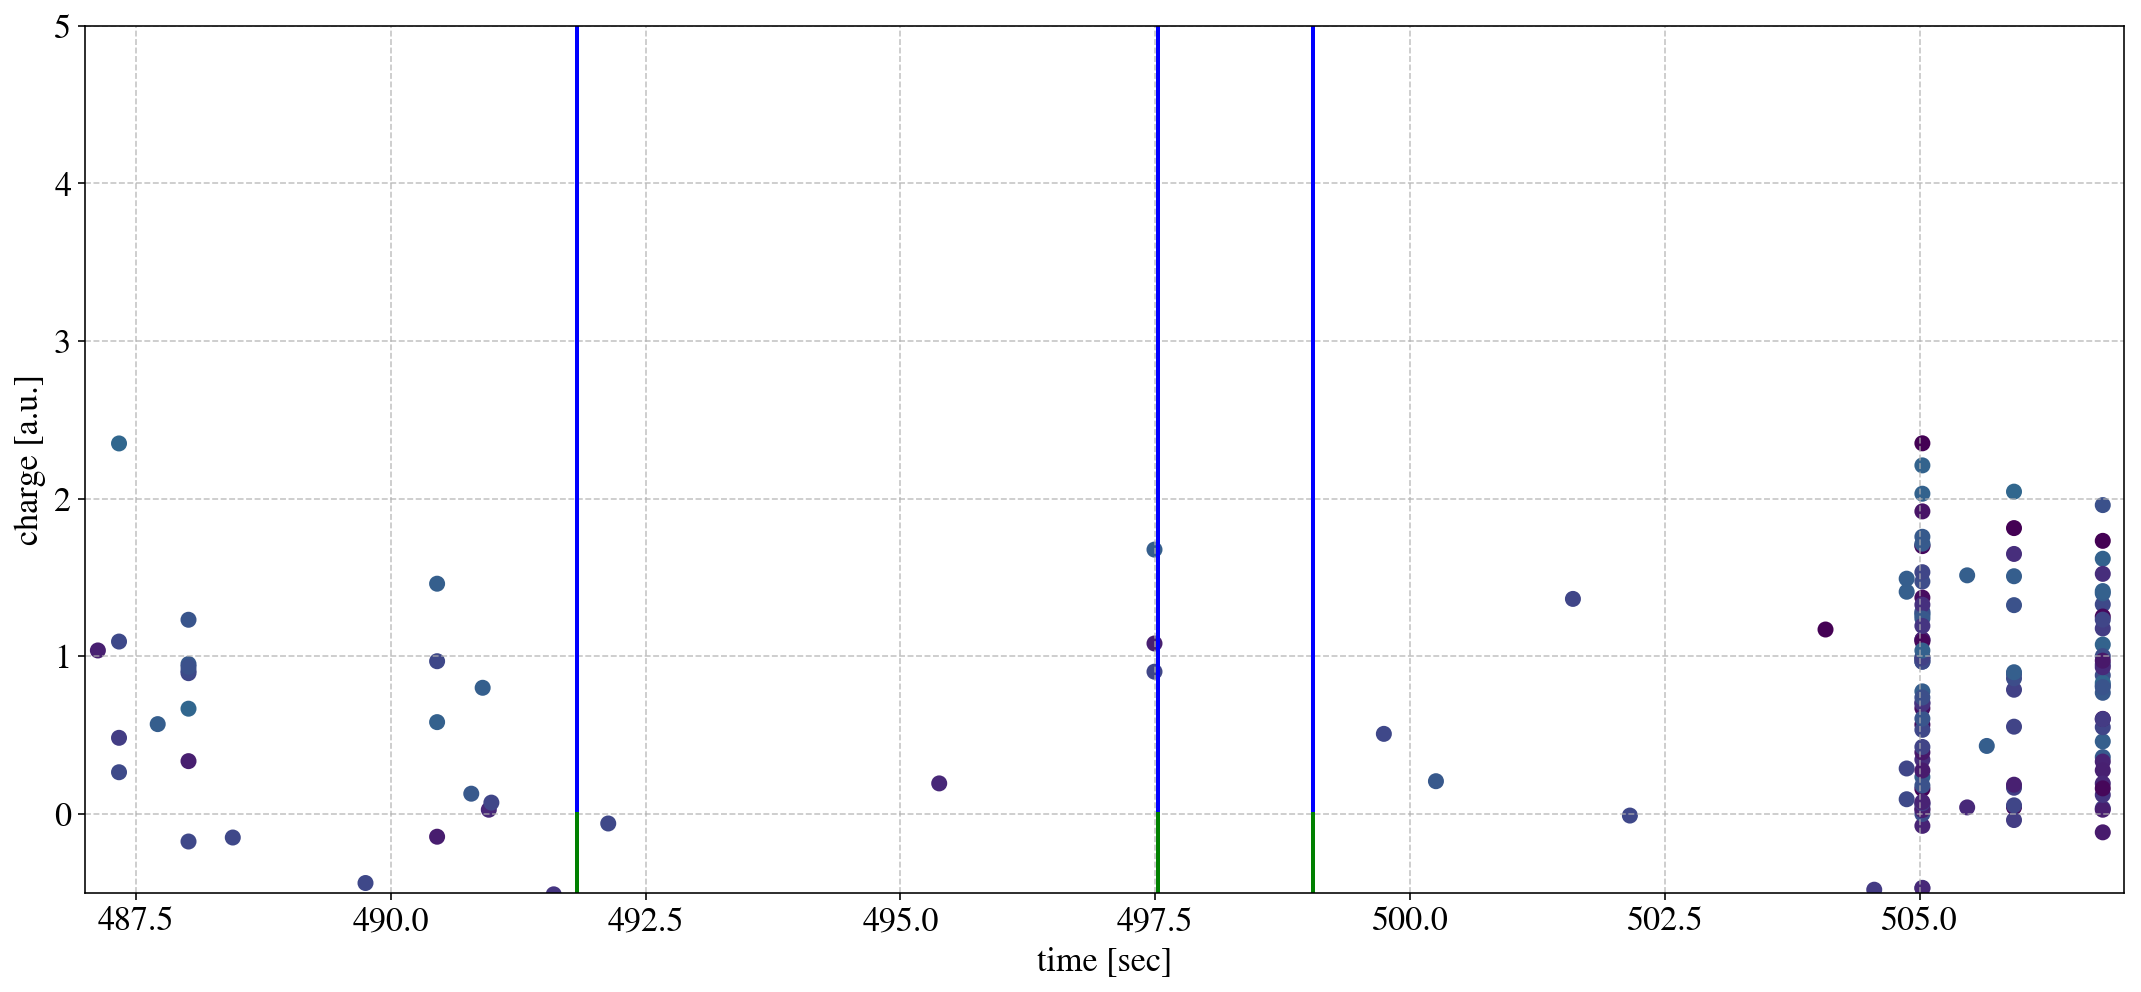

In [300]:
fig=plt.figure(figsize=(15,7)); 
ax = fig.add_subplot(1,1,1)
time = np.array(cosmic_trigg.time)
charge = np.array(cosmic_trigg.charge);
channel = np.array(cosmic_trigg.channel);
for i in range(len(time)):
    t = time[i];
    q = charge[i];
    ch = channel[i];
    if q==1:color='b'
    else: color='g'
    plt.plot( [t/sec,t/sec] , [0,q*5] , color, linewidth=2)
    
# plt.plot( scint_t/sec, scint_q ,'r.')
plt.scatter( scint_t/sec , scint_q , c=np.array(cosmic_scint.channel),linewidth=2)


set_axes(ax=ax,xlim=(497-10,497+10),
         x_label='time [sec]', y_label='charge [a.u.]', 
         fontsize=17,do_add_grid=True,do_add_legend=False,ylim=(-0.5,5));

# add events
for event in cosmic_events.values():
     plt.plot( [event['event time']/sec,event['event time']/sec] , [-1,5] , 'k' , linewidth=4, alpha=0.1)
        
plt.tight_layout()